In [1]:
import jax
from jax.experimental.multihost_utils import process_allgather
from termcolor import colored
from src.base import LBMExternalForce, LBMBase
from src.utils import *
from src.boundary_conditions import *
from src.models import BGKSim, KBCSim
from src.lattice import LatticeD2Q9
import jaxlib
# Use 8 CPU devices
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
jax.config.update('jax_enable_x64', True)


In [2]:
class Cylinder(BGKSim):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def set_boundary_conditions(self):
        # Define the cylinder surface
        coord = np.array([(i, j) for i in range(self.nx) for j in range(self.ny)])
        xx, yy = coord[:, 0], coord[:, 1]
        cx, cy = 2.*_diam, 2.*_diam
        cylinder = (xx - cx)**2 + (yy-cy)**2 <= (_diam/2.)**2
        cylinder = coord[cylinder]
        implicit_distance = np.reshape((xx - cx)**2 + (yy-cy)**2 - (_diam/2.)**2, (self.nx, self.ny))
        self.BCs.append(InterpolatedBounceBackBouzidi(tuple(cylinder.T), implicit_distance, self.gridInfo, self.precisionPolicy))

        # Outflow BC
        outlet = self.boundingBoxIndices['right']
        rho_outlet = np.ones((outlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(ExtrapolationOutflow(tuple(outlet.T), self.gridInfo, self.precisionPolicy))
        # self.BCs.append(ZouHe(tuple(outlet.T), self.gridInfo, self.precisionPolicy, 'pressure', rho_outlet))

        # Inlet BC
        inlet = self.boundingBoxIndices['left']
        rho_inlet = np.ones((inlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        vel_inlet = np.zeros(inlet.shape, dtype=self.precisionPolicy.compute_dtype)
        yy_inlet = yy.reshape(self.nx, self.ny)[tuple(inlet.T)]
        vel_inlet[:, 0] = poiseuille_profile(yy_inlet,
                                             yy_inlet.min(),
                                             yy_inlet.max()-yy_inlet.min(), 3.0 / 2.0 * _prescribed_vel)
        self.BCs.append(Regularized(tuple(inlet.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_inlet))

        # No-slip BC for top and bottom
        wall = np.concatenate([self.boundingBoxIndices['top'], self.boundingBoxIndices['bottom']])
        vel_wall = np.zeros(wall.shape, dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(Regularized(tuple(wall.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_wall))

    def output_data(self, **kwargs):
        self.saved_data.append({
            'rho':process_allgather(kwargs['rho']),
            'u':process_allgather(kwargs['u']),
            'timestep':kwargs['timestep'],
        })
        # 1:-1 to remove boundary voxels (not needed for visualization when using bounce-back)

# Helper function to specify a parabolic poiseuille profile
poiseuille_profile  = lambda x,x0,d,umax: np.maximum(0.,4.*umax/(d**2)*((x-x0)*d-(x-x0)**2))

In [3]:
from flax import linen as nn

class ConvBlock(nn.Module):
  """Defines a convolutional block with activation and normalization."""
  features: int
  kernel_size: int = (3,3)
  strides: int = 1

  @nn.compact
  def __call__(self, inputs):
    x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(inputs)
    x = nn.BatchNorm(use_running_average=True)(x)
    x = nn.relu(x)
    return x

class DownBlock(nn.Module):
  """Downsamples feature maps through convolutions and pooling."""
  features: int
  pool_factor: int = 2

  @nn.compact
  def __call__(self, x):
    x = ConvBlock(self.features)(x)
    x = ConvBlock(self.features)(x)
    return x

class UpBlock(nn.Module):
  """Upsamples feature maps and concatenates with features from the contracting path."""
  features: int
  up_factor: int = 2

  @nn.compact
  def __call__(self, x):
    x = ConvBlock(self.features)(x)
    x = ConvBlock(self.features)(x)
    x = nn.ConvTranspose(self.features, kernel_size=(2, 2), strides=self.up_factor, padding='VALID')(x)
    return x

class UNet(nn.Module):
  """UNet architecture with contracting and expanding paths."""
  features_start: int = 64

  @nn.compact
  def __call__(self, x):
    input_shape = x.shape
    # Contracting path
    down1 = DownBlock(self.features_start * 2)(x)
    down1_max_pooled = nn.max_pool(down1, window_shape=(2, 2), strides=(2, 2))
    down2 = DownBlock(self.features_start * 4)(down1_max_pooled)
    down2_max_pooled = nn.max_pool(down2, window_shape=(2, 2), strides=(2, 2))
    down3 = DownBlock(self.features_start * 8)(down2_max_pooled)
    down3_max_pooled = nn.max_pool(down3, window_shape=(2, 2), strides=(2, 2))
    down4 = DownBlock(self.features_start * 16)(down3_max_pooled)
    down4_max_pooled = nn.max_pool(down4, window_shape=(2, 2), strides=(2, 2))
    
    # Expanding path with concatenation
    up1 = UpBlock(self.features_start * 16)(down4_max_pooled)
    down4_sliced = jax.lax.slice(down4, (4, 4, 0),(down4.shape[0]-4, down4.shape[1]-4, down4.shape[2]))
    up1_concatenated = jax.lax.concatenate([down4_sliced, up1], dimension=2)
    up2 = UpBlock(self.features_start * 4)(up1_concatenated)
    down3_sliced = jax.lax.slice(down3, (4, 4, 0), (down3.shape[0]-4, down3.shape[1]-4, down3.shape[2]))
    up2_concatenated = jax.lax.concatenate([down3_sliced, up2], dimension=2)
    up3 = UpBlock(self.features_start * 2)(up2_concatenated)
    print(up3.shape)
    return up3
  
class SimpleNet(nn.Module):
    features: int = 32
    kernel_size: int = (5, 5)
    strides: int = 1
    @nn.compact
    def __call__(self, x):
        # x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        # x = nn.leaky_relu(x)
        # x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        # x = nn.leaky_relu(x)
        x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.features)(x)
        x = nn.Conv(2, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        return x


In [4]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 440, 82, 2]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

@jax.jit
def train_step(state, ref_data, low_res_lbm_solver: LBMBase):
  """Train for a single step."""
  frame_idx = 0
  input_frame=ref_data[frame_idx]
  ref_frame=ref_data[frame_idx+1]
  ts = input_frame['timestep']
  rho = input_frame['rho']
  u = input_frame['u']
  f = low_res_lbm_solver.equilibrium(rho, u, False)
  low_res_lbm_solver.run_step(ts+1, ts, f)
  output_frame=low_res_lbm_solver.saved_data[0]
  def loss_fn(params):
    correction = state.apply_fn({'params': params}, low_res_lbm_solver.saved_data[0]['u'])
    loss = optax.l2_loss(output_frame['u']+correction, ref_frame['u'])
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def pred_step(state, batch):
  return state.apply_fn({'params': state.params}, batch)
init_rng = jax.random.key(0)
learning_rate = 0.01
momentum = 0.9
from tqdm import tqdm
my_unet = SimpleNet()
state = create_train_state(my_unet, init_rng, learning_rate, momentum)

In [5]:
class BGKSimForce(LBMExternalForce):
    """
    BGK simulation class.

    This class implements the Bhatnagar-Gross-Krook (BGK) approximation for the collision step in the Lattice Boltzmann Method.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @partial(jit, static_argnums=(0,))
    def collision(self, f, feq, rho, u):
        """
        BGK collision step for lattice.

        The collision step is where the main physics of the LBM is applied. In the BGK approximation, 
        the distribution function is relaxed towards the equilibrium distribution function.
        """
        fneq = f - feq
        fout = f - self.omega * fneq
        return self.precisionPolicy.cast_to_output(fout)

class CylinderForce(BGKSimForce):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def set_boundary_conditions(self):
        # Define the cylinder surface
        coord = np.array([(i, j) for i in range(self.nx) for j in range(self.ny)])
        xx, yy = coord[:, 0], coord[:, 1]
        cx, cy = 2.*_diam, 2.*_diam
        cylinder = (xx - cx)**2 + (yy-cy)**2 <= (_diam/2.)**2
        cylinder = coord[cylinder]
        implicit_distance = np.reshape((xx - cx)**2 + (yy-cy)**2 - (_diam/2.)**2, (self.nx, self.ny))
        self.BCs.append(InterpolatedBounceBackBouzidi(tuple(cylinder.T), implicit_distance, self.gridInfo, self.precisionPolicy))

        # Outflow BC
        outlet = self.boundingBoxIndices['right']
        rho_outlet = np.ones((outlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(ExtrapolationOutflow(tuple(outlet.T), self.gridInfo, self.precisionPolicy))
        # self.BCs.append(ZouHe(tuple(outlet.T), self.gridInfo, self.precisionPolicy, 'pressure', rho_outlet))

        # Inlet BC
        inlet = self.boundingBoxIndices['left']
        rho_inlet = np.ones((inlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        vel_inlet = np.zeros(inlet.shape, dtype=self.precisionPolicy.compute_dtype)
        yy_inlet = yy.reshape(self.nx, self.ny)[tuple(inlet.T)]
        vel_inlet[:, 0] = poiseuille_profile(yy_inlet,
                                             yy_inlet.min(),
                                             yy_inlet.max()-yy_inlet.min(), 3.0 / 2.0 * _prescribed_vel)
        self.BCs.append(Regularized(tuple(inlet.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_inlet))

        # No-slip BC for top and bottom
        wall = np.concatenate([self.boundingBoxIndices['top'], self.boundingBoxIndices['bottom']])
        vel_wall = np.zeros(wall.shape, dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(Regularized(tuple(wall.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_wall))

    def output_data(self, **kwargs):
        self.saved_data.append(kwargs['u'])
        # 1:-1 to remove boundary voxels (not needed for visualization when using bounce-back)
    
    @partial(jit, static_argnums=(0,))
    def get_force(self, f_postcollision, feq, rho, u):
        return state.apply_fn({'params': state.params}, u)

In [6]:
def generate_sim_dataset(diam, t_start, t_end, output_stride, output_offset):
    global _diam
    global _prescribed_vel
    _diam = diam
    precision = 'f64/f64'
    # diam_list = [10, 20, 30, 40, 60, 80]
    scale_factor = 80 / diam
    prescribed_vel = 0.003 * scale_factor
    _prescribed_vel = prescribed_vel
    lattice = LatticeD2Q9(precision)

    nx = int(22*diam)
    ny = int(4.1*diam)

    Re = 100.0
    visc = prescribed_vel * diam / Re
    omega = 1.0 / (3. * visc + 0.5)
    kwargs = {
        'lattice': lattice,
        'omega': omega,
        'nx': nx,
        'ny': ny,
        'nz': 0,
        'precision': precision,
        'return_fpost': True    # Need to retain fpost-collision for computation of lift and drag
    }
    # characteristic time
    tc = prescribed_vel/diam
    if t_end < int(100//tc):
        print(colored("WARNING: timestep_end is too small, Karman flow may not appear. Recommend value is {}".format(int(100//tc)), "red"))
    sim = Cylinder(**kwargs)
    return sim.run_batch_generator(t_end, t_start, output_offset, output_stride, generator_size=100)
    # return sim.saved_data

def generate_sim_dataset_with_profile(diam, t_start, t_end, output_stride, output_offset):
    with jax.profiler.trace("/tmp/tensorboard"):
        generated_data = generate_sim_dataset(diam, t_start, t_end, output_stride, output_offset)
        jax.profiler.save_device_memory_profile("memory.prof")
    return generated_data

In [7]:
def process_batched_data(batched_data, seq_num):
    output_np_data = {
        'timestep' :[],
        'u': [],
        'rho': []
    }
    for frame in batched_data:
        output_np_data['timestep'].append(frame['timestep'])
        output_np_data['u'].append(frame['u'])
        output_np_data['rho'].append(frame['rho'])
    output_np_data['timestep'] = np.array(output_np_data['timestep'])
    output_np_data['u'] = np.stack(output_np_data['u'], axis=0)
    output_np_data['rho'] = np.stack(output_np_data['rho'], axis=0)
    np.savez_compressed("./data/batched_ref_data_{}.npz".format(seq_num), timestep=output_np_data['timestep'], u=output_np_data['u'], rho=output_np_data['rho'])
    print("Seq {} saved".format(seq_num))
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=24) as executor:
    seq = 0
    tasks = []
    for batched_data in generate_sim_dataset(80, 0, 20000, 1, 19900):
        tasks.append(executor.submit(process_batched_data, batched_data, seq))
        seq += 1
        if len(tasks) == 10:
            print("Finishing tasks...")
            for task in tqdm(tasks):
                task.result()
            tasks = []

**** Simulation Parameters for Cylinder ****
            Parameter | Value
--------------------------------------------------
                Omega | 1.971608832807571
     Grid Points in X | 1760
     Grid Points in Y | 328
     Grid Points in Z | 0
       Dimensionality | 2
     Precision Policy | f64/f64
         Lattice Type | D2Q9
      Checkpoint Rate | 0
 Checkpoint Directory | ./checkpoints
  Downsampling Factor | 1
      Print Info Rate | 100
             I/O Rate | 0
        Compute MLUPS | False
   Restore Checkpoint | False
              Backend | gpu
    Number of Devices | 1
Time to create the grid mask: 0.13887929916381836
Time to create the local masks and normal arrays: 0.805060863494873
         To set explicit initial density and velocity, use self.initialize_macroscopic_fields.


 36%|███▌      | 7149/20001 [00:56<01:41, 127.17it/s]


KeyboardInterrupt: 

In [ ]:
for task in tqdm(tasks):
        task.result()

In [7]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
def visualize_frames(data, imgs=20, field='u'):
    fig, axs = plt.subplots(1, imgs, figsize=(32, 10))
    max_val = data[0]['u'][np.where(data[0]['u'] == data[0]['u'].max())]
    min_val = data[0]['u'][np.where(data[0]['u'] == data[0]['u'].min())]
    for i in range(imgs):
        img = (data[i*(len(data)//imgs)][field] - min_val)/(max_val - min_val)
        img = np.concatenate((img, np.zeros((img.shape[0], img.shape[1], 1))), axis=2)
        axs[i].imshow(img)
        axs[i].set_title("T={}".format(data[i*(len(data)//imgs)]['timestep']))

def visualize_data(data, imgs=20, field='u'):
    fig, axs = plt.subplots(1, imgs, figsize=(32, 10))
    max_val = data[field][np.where(data[field] == data[field].max())]
    min_val = data[field][np.where(data[field] == data[field].min())]
    for i in range(imgs):
        img = (data[field][i*(len(data['timestep'])//imgs)] - min_val)/(max_val - min_val)
        img = np.concatenate((img, np.zeros((img.shape[0], img.shape[1], 1))), axis=2)
        axs[i].imshow(img)
        axs[i].set_title("T={}".format(i*(len(data['timestep'])//imgs)))
        

def inspect_frames(data):
    print(colored("*** Data Summary ***", "red"))
    if len(data)==1:
        print(colored("Single frame at timestep: {}".format(data[0]['timestep']), "green"))
        return
    else:
        print(colored("Timestep: first frame at T={} - last frame at T={}".format(data[0]['timestep'], data[-1]['timestep']), 'blue'))
        print(colored("Timestep stride: {}".format(data[1]['timestep']-data[0]['timestep']), 'blue'))
    print(colored("Frame attributes:", 'blue'))
    for i in data[0].keys():
        print(colored('\t{}'.format(i), 'green'), end=" ")
        if data[0][i] is None:
            print(None)
        elif type(data[0][i])==np.ndarray:
            print("numpy array shape: {}".format(data[0][i].shape))
        elif type(data[0][i])==jaxlib.xla_extension.ArrayImpl:
            print("jax array shape: {}".format(data[0][i].shape))
        elif type(data[0][i])==int:
            print("int")
        else:
            print(type(data[0][i]))
def read_data():
    res_data = {
        'timestep':[],
        'rho':[],
        'u':[]
    }
    total_batch = 1
    for i in tqdm(range(total_batch)):
        loaded_data = np.load('./data/batched_ref_data_{}.npz'.format(i))
        res_data['timestep'].append(loaded_data['timestep'])
        res_data['rho'].append(loaded_data['rho'])
        res_data['u'].append(loaded_data['u'])
    res_data['timestep'] = np.concatenate(res_data['timestep'], axis=0)
    res_data['rho'] = np.concatenate(res_data['rho'], axis=0)
    res_data['u'] = np.concatenate(res_data['u'], axis=0)
    return res_data

def resample_field_np(field, x_axis, y_axis, factor):
    new_shape = (round(indices/factor) if indices==x_axis or indices==y_axis else indices for indices in field.shape)
    print(new_shape)
    return np.resize(field, new_shape)

def read_data_and_downsample(factor=4):
    res_data = {
        'timestep':[],
        'rho':[],
        'u':[]
    }
    total_batch = 1
    for i in tqdm(range(total_batch)):
        loaded_data = np.load('./data/batched_ref_data_{}.npz'.format(i))
        resized_shape = (loaded_data['u'].shape[0], round(loaded_data['u'].shape[1]/factor), round(loaded_data['u'].shape[2]/factor))
        res_data['timestep'].append(loaded_data['timestep'])
        res_data['rho'].append(resample_field(loaded_data['rho'], factor, shape=(resized_shape[0], resized_shape[1], resized_shape[2], loaded_data['rho'].shape[3])))
        res_data['u'].append(resample_field(loaded_data['u'], factor, shape=(resized_shape[0], resized_shape[1], resized_shape[2], loaded_data['u'].shape[3])))
    res_data['timestep'] = np.concatenate(res_data['timestep'], axis=0)
    res_data['rho'] = np.concatenate(res_data['rho'], axis=0)
    res_data['u'] = np.concatenate(res_data['u'], axis=0)
    return res_data

In [8]:
d = read_data_and_downsample()

100%|██████████| 1/1 [00:23<00:00, 23.81s/it]


In [9]:
d['u'].shape

(100, 440, 82, 2)

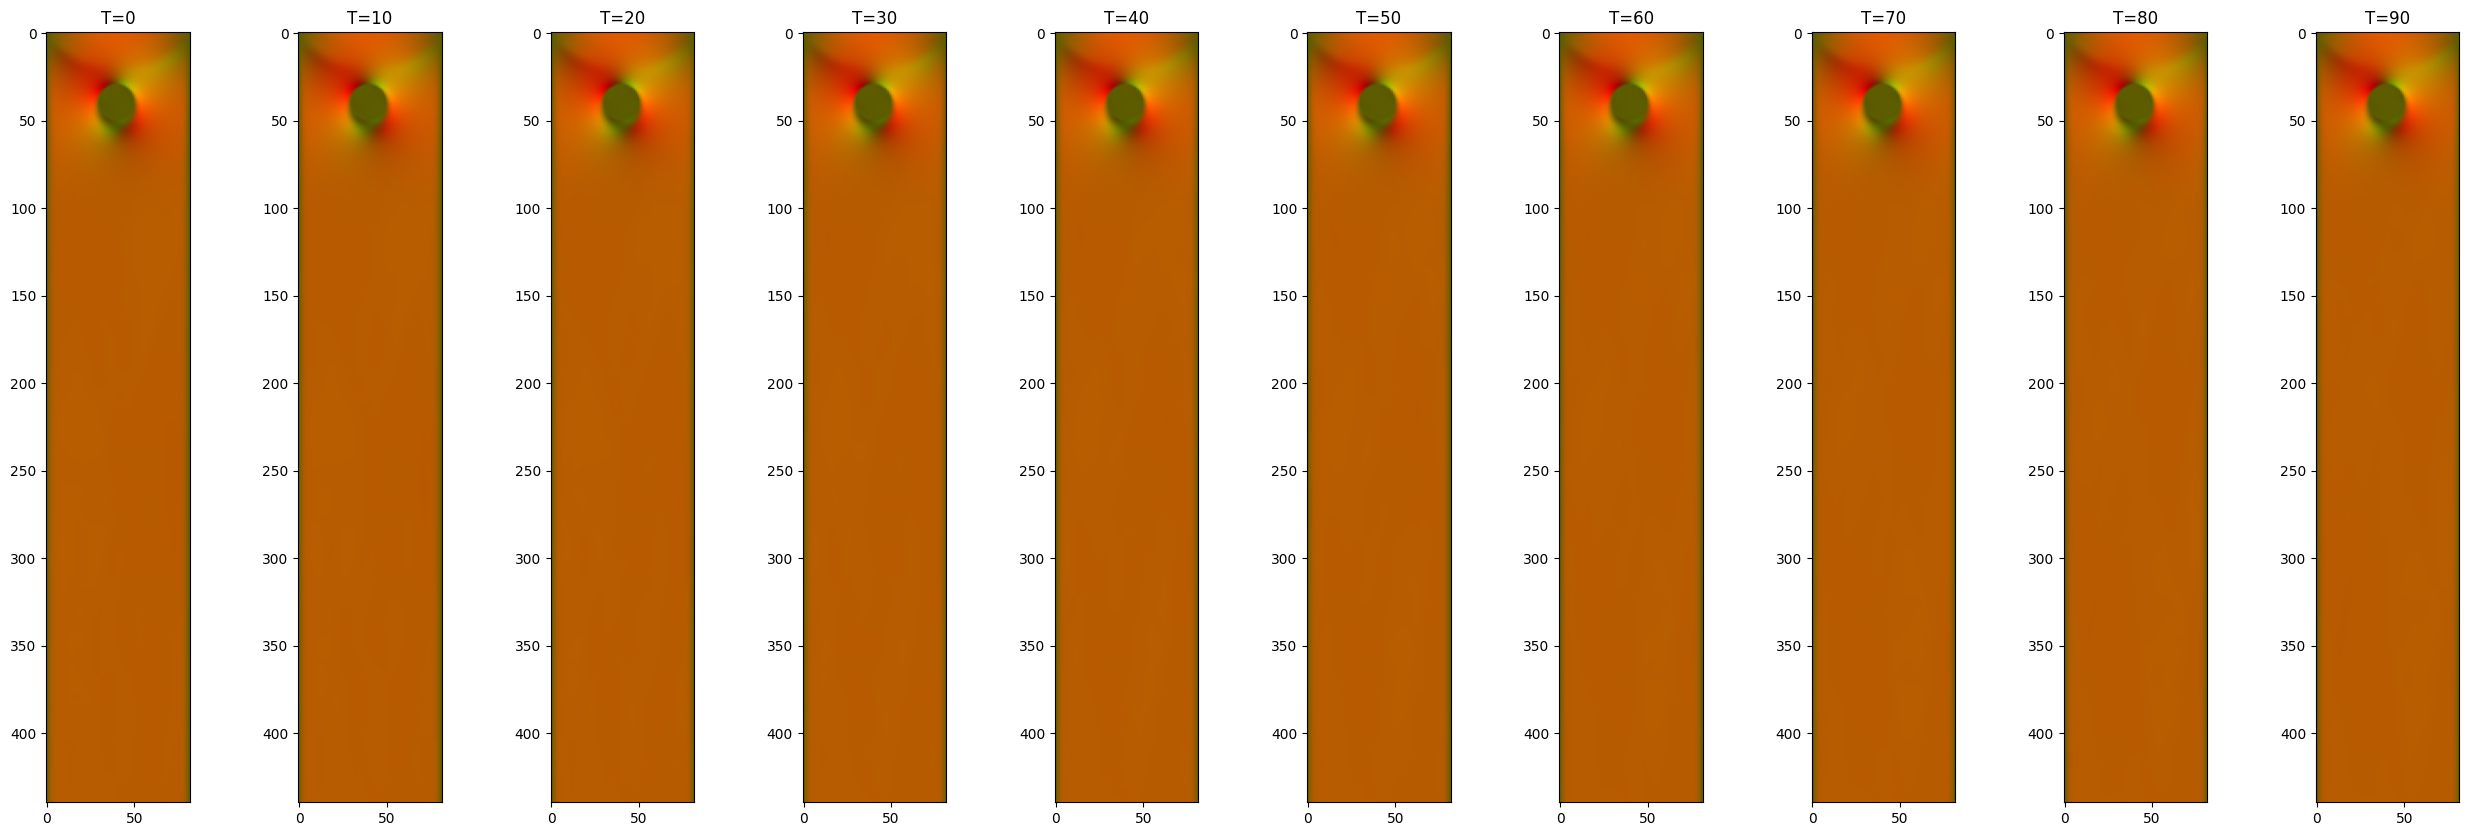

In [10]:
visualize_data(d, 10)